Note : Due to pc problems, I couldn't finish training LSTM


In [13]:
import dateutil.parser
from dateutil.parser import parse 
import pandas as pd  # This is always assumed but is included here as an introduction.
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series

from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import seaborn as sns
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


![image.png](attachment:image.png)

In [14]:
dfb = pd.read_csv('consommation-quotidienne-brute_tr1.csv',sep=';',parse_dates=['Date - Heure','Date'])

# permet de trier les données, créer un index
dfb1 = dfb.sort_values(by='Date - Heure')
dfb1.loc[:,'Date - Heure'] = pd.to_datetime(dfb1.loc[:,'Date - Heure'],utc=True)
dfb1.index = dfb1.loc[:,'Date - Heure']

dftr = dfb1[['Consommation brute électricité (MW) - RTE']]

## Visualisation des données

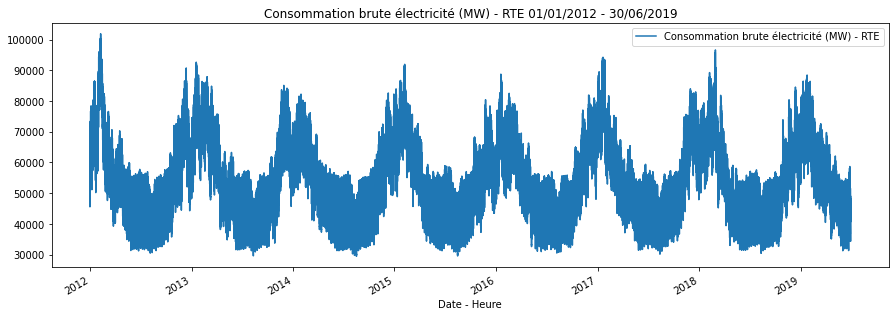

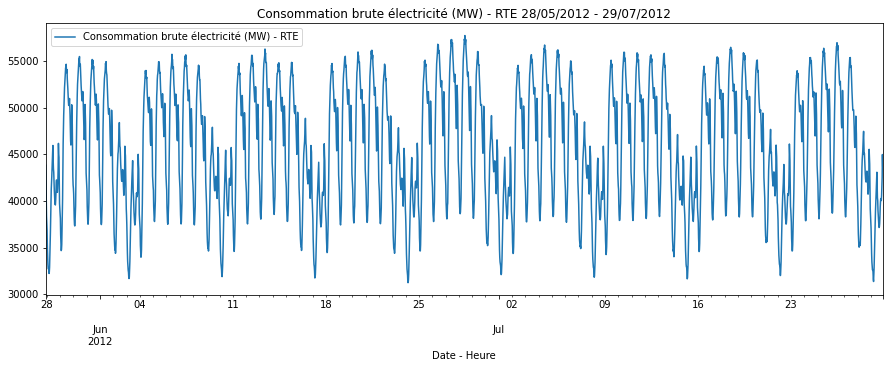

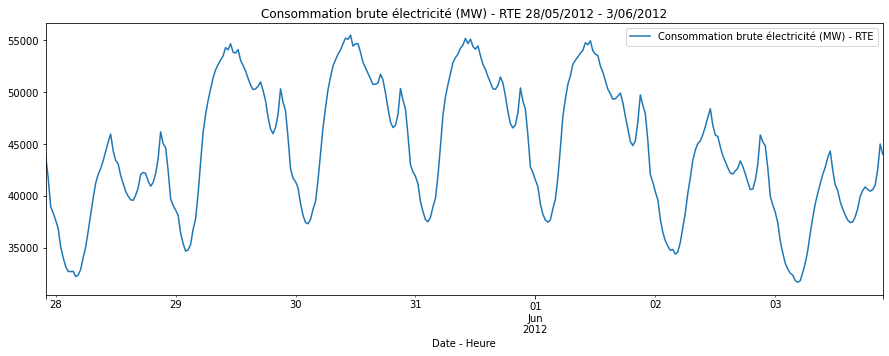

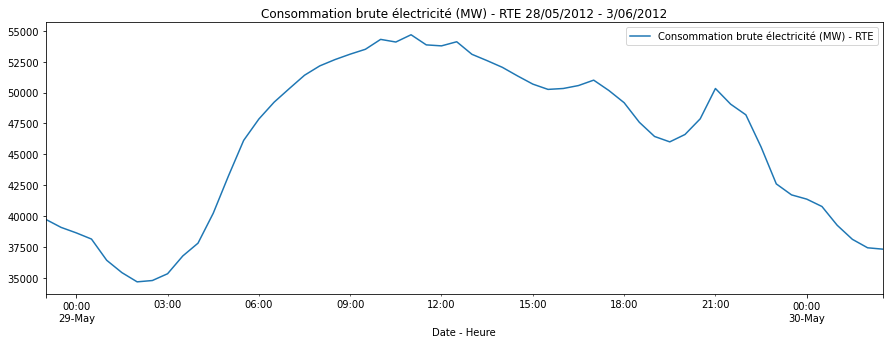

In [15]:
# Affichage

dftr.plot(figsize=(15,5), title='Consommation brute électricité (MW) - RTE 01/01/2012 - 30/06/2019')

dftr[7104:10128].plot(figsize=(15,5), title= 'Consommation brute électricité (MW) - RTE 28/05/2012 - 29/07/2012') 

dftr[7104:7440].plot(figsize=(15,5), title = 'Consommation brute électricité (MW) - RTE 28/05/2012 - 3/06/2012') 

dftr[7154:7210].plot(figsize=(15,5), title = 'Consommation brute électricité (MW) - RTE 28/05/2012 - 3/06/2012') 


Saisonnalités multiples : année, semaine, jour, 

Le première figure affiche l'intégralité de l'intervalle de temps.
Afficher 131424 valeurs donne cette effet de "ruban".
On remarque qu'une périodicité annuelle est possible.

La deuxième figure affiche une période de temps de 9 semaines. 
On remarque un pattern qui semble périodique sur une semaine et qui ne semble pas évoluer dans le temps.

La troisième figure (1 semaine) fait afficher une périodicité journalière (on peut distinguer 3 types de journées : les lundi-mardi-mercredi-jeudi, le vendredi, les samedi-dimanche

La quatrième figure fait affiche un lundi.

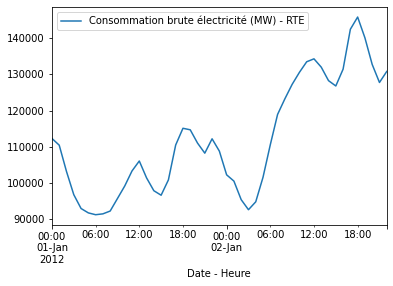

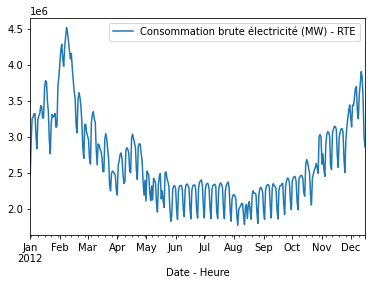

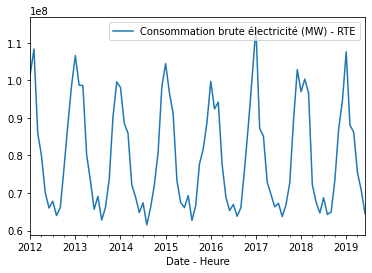

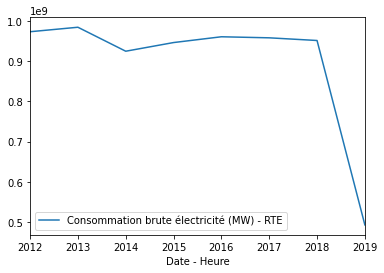

In [16]:
dfth = dftr.resample('H', convention='end').sum()
dfth[1:48][['Consommation brute électricité (MW) - RTE']].plot()

dftd = dftr.resample('D', convention='end').sum()
dftd[1:352][['Consommation brute électricité (MW) - RTE']].plot()

dftm = dftr.resample('M', convention='end').sum()
dftm[1:][['Consommation brute électricité (MW) - RTE']].plot()

dfty = dftr.resample('Y', convention='end').sum()
dfty[1:][['Consommation brute électricité (MW) - RTE']].plot()

del dftm
del dfty
del dfth

On divisera la période d'observation en deux périodes. La deuxième période aura une durée de six mois.

## Dividing the dataframe into 2 periods, with second period the last six months

In [17]:
# start_date = dftr.index[-1] - pd.tseries.offsets.MonthBegin(6)
# first_diff = dftr['Consommation brute électricité (MW) - RTE'] - dftr['Consommation brute électricité (MW) - RTE'].shift(1)
# first_diff.dropna(inplace = True)
# dftd_train, dftd_test = dftr[:start_date],dftr[start_date:]


In [18]:
#Due to length of training let's reduce the corpus
start_date = dftr.index[-1] - pd.tseries.offsets.MonthBegin(66)
end_date = dftr.index[-1] - pd.tseries.offsets.MonthBegin(60)

first_diff = dftr['Consommation brute électricité (MW) - RTE'] - dftr['Consommation brute électricité (MW) - RTE'].shift(1)
first_diff.dropna(inplace = True)
dftd_train, dftd_test = dftr[:start_date],dftr[start_date:end_date]


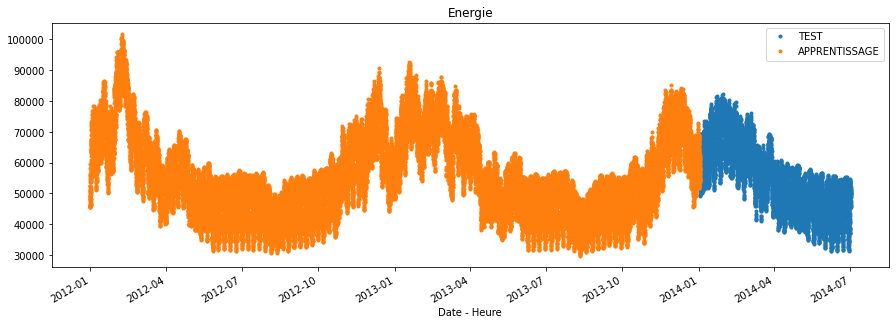

In [19]:
dftd_test \
    .rename(columns={'Consommation brute électricité (MW) - RTE': 'TEST'}) \
    .join(dftd_train.rename(columns={'Consommation brute électricité (MW) - RTE': 'APPRENTISSAGE'}), how='outer') \
    .plot(figsize=(15,5), title='Energie', style='.');

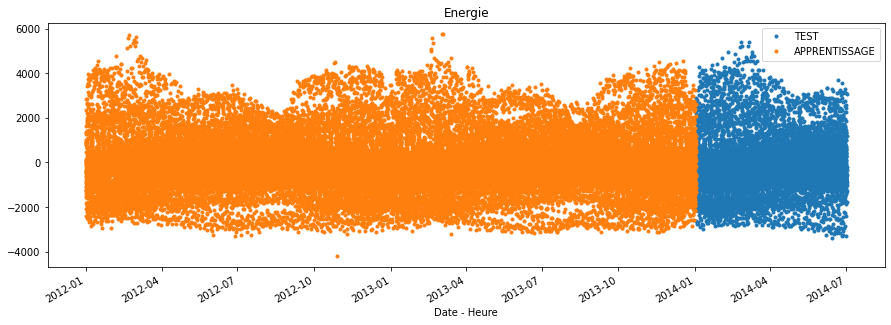

In [20]:
# start_date = dftr.index[-1] - pd.tseries.offsets.MonthBegin(6)

dftd_train, dftd_test = pd.DataFrame({'y':first_diff[:start_date]}),pd.DataFrame({'y':first_diff[start_date:end_date]})
dftd_test \
    .rename(columns={'y': 'TEST'}) \
    .join(dftd_train.rename(columns={'y': 'APPRENTISSAGE'}), how='outer') \
    .plot(figsize=(15,5), title='Energie', style='.');

In [21]:
dftd_test.shape

(8691, 1)

 ### Estimer les paramètres du modèles sur la première période

### Multi-Step LSTM Models
A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting.

Specifically, these are problems where the forecast horizon or interval is more than one time step.

There are two main types of LSTM models that can be used for multi-step forecasting; they are:

Vector Output Model
Encoder-Decoder Model

In [24]:
# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# multi-step data preparation
from numpy import array

#split_sequence() function below will split 
#a given univariate time series into samples with a specified number of input and output time steps.
# def split_sequence(sequence, n_steps_in, n_steps_out):
#         X, y = list(), list()
#         for i in range(len(sequence)):
#             # find the end of this pattern
#             end_ix = i + n_steps_in
#             out_end_ix = end_ix + n_steps_out
#             # check if we are beyond the sequence
#             if out_end_ix > len(sequence):
#                 break
#             # gather input and output parts of the pattern
#             seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
#             X.append(seq_x)
#             y.append(seq_y)
#         return array(X), array(y)
# convert into dataset matrix
def convertToMatrix(data, n_steps_in, n_steps_out):
 X, Y =[], []
 for i in range(len(data)-n_steps_in-n_steps_out):
    d=i+n_steps_in
    f = d + n_steps_out  
    X.append(data[i:d,])
    Y.append(data[d:f])
 return np.array(X), np.array(Y)

# define input sequence
# raw_train_seq = list(np.asarray(dftd_train.y))
# del dftd_train
# del dfb
# del dftr
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 17473, 8691
# split into samples
X,y =convertToMatrix(np.asarray(dftd_train.y),n_steps_in, n_steps_out)

# X, y = split_sequence(raw_train_seq, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X)):
        print(X[i], y[i])

Streaming output truncated to the last 5000 lines.
[-634.  -94.  457. ... -805. -675. -266.] [ 174. 1111. 1479. ... -410.  318.  915.]
[ -94.  457. 1281. ... -675. -266.  174.] [1111. 1479. 3178. ...  318.  915. 1588.]
[ 457. 1281. 2633. ... -266.  174. 1111.] [1479. 3178. 2325. ...  915. 1588.  317.]
[1281. 2633. 2987. ...  174. 1111. 1479.] [3178. 2325. -415. ... 1588.  317.  489.]
[2633. 2987.  563. ... 1111. 1479. 3178.] [ 2325.  -415. -1852. ...   317.   489.   -79.]
[ 2987.   563. -1689. ...  1479.  3178.  2325.] [ -415. -1852. -1842. ...   489.   -79. -1554.]
[  563. -1689. -1591. ...  3178.  2325.  -415.] [-1852. -1842. -1807. ...   -79. -1554. -2263.]
[-1689. -1591. -1472. ...  2325.  -415. -1852.] [-1842. -1807. -1228. ... -1554. -2263. -1710.]
[-1591. -1472. -1456. ...  -415. -1852. -1842.] [-1807. -1228.   161. ... -2263. -1710.   -52.]
[-1472. -1456.   140. ... -1852. -1842. -1807.] [-1228.   161.  2516. ... -1710.   -52.  2016.]
[-1456.   140.  2185. ... -1842. -1807. -12

### Vector Output Model
Like other types of neural network models, the LSTM can output a vector directly that can be interpreted as a multi-step forecast.
the prepared samples must first be reshaped. The LSTM expects data to have a three-dimensional structure of [samples, timesteps, features], and in this case, we only have one feature so the reshape is straightforward.

In [25]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [26]:
# define model
model = Sequential()
model.add(LSTM(1, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(1, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
history = model.fit(X, y, epochs=50, verbose=0)


In [ ]:
# demonstrate prediction
x_input = list(np.asarray(dftd_test.y))
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
# demonstrate prediction
start_date = dftd_train.index[-1] - pd.tseries.offsets.MonthBegin(12)
x_test= pd.DataFrame({'y':first_diff[:start_date]})
y_test = list(np.asarray(dftd_test.y))
x_input = np.asarray(x_test.y)

x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
# print(yhat)

### Prediction metrics

In [ ]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Make predictions using the training and testing set
y_train_pred = model.predict(X)
y_test_pred = yhat

In [ ]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

print('The Mean absolute percent accuracy (MAPA) is :%.1f' % (100 - mean_absolute_percentage_error(y_test, y_test_pred)))